# Interpolating between cosmological simulation snapshots using machine learning

## Masters of Artificial Intelligence and Data Science in the University of Hull by Daniyal Kaleem May 2025


### Note to Evaluator: 

### This notebook serves as the secondary submission, provided solely for the purpose of supporting and elaborating on the theoretical aspects discussed.

# Importing the Libraries

In [1]:
import h5py
import hdf5plugin
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Loading data from the hdf5 file

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Function to load coordinates from HDF5 files
def load_hdf5_data(filenames):
    data_list = []
    for file in filenames:
        with h5py.File(file, 'r') as f:
            coords = f['PartType1/Coordinates'][:]  # Shape: (num_particles, 3)
            data_list.append(coords)

    # Stack data into a single array
    data = np.concatenate(data_list, axis=0)  # Combine all snapshots
    return data


In [3]:
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Load data from HDF5 files
train_files = ["snapshot_076.hdf5", "snapshot_078.hdf5", "snapshot_080.hdf5", "snapshot_082.hdf5", "snapshot_084.hdf5", "snapshot_086.hdf5", "snapshot_088.hdf5"]
test_file = "snapshot_090.hdf5"

train_data = load_hdf5_data(train_files)  # Shape (N, 3)
test_data = load_hdf5_data([test_file])  # Shape (N, 3)

# Function to create 2D density maps efficiently
def create_2d_grid(data, grid_size=256):
    grid, _, _ = np.histogram2d(data[:, 0], data[:, 1], bins=grid_size)
    return grid


# Making 2d Maps of the 3D figure

In [5]:
# Convert to 2D density maps
train_maps = np.array([create_2d_grid(train_data) for _ in range(700)])
test_maps = np.array([create_2d_grid(test_data) for _ in range(100)])

# Normalize efficiently
train_maps = np.log10(train_maps + 1e-5)
test_maps = np.log10(test_maps + 1e-5)

train_maps = (train_maps - train_maps.min()) / (train_maps.max() - train_maps.min())
test_maps = (test_maps - test_maps.min()) / (test_maps.max() - test_maps.min())

# Reshape for PyTorch
train_maps = train_maps[..., np.newaxis]  # (N, 256, 256, 1)
test_maps = test_maps[..., np.newaxis]

# Train and Test validation split

In [6]:
# Fast train-validation split
split_idx = int(0.9 * len(train_maps))
val_maps = train_maps[split_idx:]
train_maps = train_maps[:split_idx]

print(f"Train shape: {train_maps.shape}, Validation shape: {val_maps.shape}, Test shape: {test_maps.shape}")


Train shape: (630, 256, 256, 1), Validation shape: (70, 256, 256, 1), Test shape: (100, 256, 256, 1)


In [7]:
# Dataset class
class NBodyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data) - 1

    def __getitem__(self, idx):
        x, y = self.data[idx], self.data[idx + 1]
        x = np.transpose(x, (2, 0, 1))  # (1, 256, 256)
        y = np.transpose(y, (2, 0, 1))  
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


# DataLoaders

In [8]:
# DataLoaders
train_loader = DataLoader(NBodyDataset(train_maps), batch_size=16, shuffle=True)
val_loader = DataLoader(NBodyDataset(val_maps), batch_size=16, shuffle=False)
test_loader = DataLoader(NBodyDataset(test_maps), batch_size=16, shuffle=False)


# Check batch shape
for inputs, targets in train_loader:
    print(f"Batch Input shape: {inputs.shape}, Batch Target shape: {targets.shape}")
    break

Batch Input shape: torch.Size([16, 1, 256, 256]), Batch Target shape: torch.Size([16, 1, 256, 256])


# Defining the Initial U-Net Structure

In [9]:
class UNet(nn.Module):
    """A simplified UNet architecture for image processing tasks.
    
    This implementation features a basic encoder-decoder structure with skip connections
    omitted for simplicity. The network follows the traditional UNet design pattern but
    with reduced complexity for educational/demonstration purposes.
    
    Architecture:
        - Encoder: Two downsampling blocks (conv + ReLU + maxpool)
        - Middle: Single convolutional bottleneck layer
        - Decoder: Two upsampling blocks (transposed conv + ReLU) + final output conv
        
    Note: This is a minimal implementation missing some UNet features like:
        - Skip connections between encoder and decoder
        - Batch normalization layers
        - More sophisticated channel progression
    """
    def __init__(self):
        """Initialize the UNet layers and components."""
        super(UNet, self).__init__()
        
        # Encoder layers
        # Two downsampling blocks that reduce spatial dimensions while increasing channel depth
        # Each block consists of:
        #   - Conv2d with kernel_size=3 and padding=1 (to maintain spatial dimensions)
        #   - ReLU activation
        #   - MaxPool2d with stride=2 (halving spatial dimensions)
        self.encoder = nn.Sequential(
            # First downsampling block: 1->32 channels
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Second downsampling block: 32->64 channels
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Middle layer (bottleneck)
        # Processes the most compressed representation at 128 channels
        # Maintains spatial dimensions through padding
        self.middle = nn.Conv2d(64, 128, 3, padding=1)
        
        # Decoder layers
        # Two upsampling blocks that increase spatial dimensions while decreasing channel depth
        # Each block uses transposed convolution for upsampling
        # Final output layer reduces to single channel with standard convolution
        self.decoder = nn.Sequential(
            # First upsampling block: 128->64 channels, 2x spatial upsampling
            nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU(),
            
            # Second upsampling block: 64->32 channels, 2x spatial upsampling
            nn.ConvTranspose2d(64, 32, 2, stride=2), nn.ReLU(),
            
            # Final output layer: 32->1 channel, maintains spatial dimensions
            nn.Conv2d(32, 1, 3, padding=1)
        )

    def forward(self, x):
        """Forward pass through the UNet architecture.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 1, height, width)
            
        Returns:
            torch.Tensor: Output tensor of shape (batch_size, 1, height, width)
        """
        # Encoder pathway (contracting)
        x = self.encoder(x)
        
        # Bottleneck processing
        x = self.middle(x)
        
        # Decoder pathway (expanding)
        x = self.decoder(x)
        
        return x

# Training for 10 epochs

In [10]:
# Model setup
UNetReLU_model_1 = UNet().to(device)           # Initialize the U-Net model and move it to the selected device (CPU/GPU)
criterion = nn.MSELoss()                       # Define loss function (Mean Squared Error)
optimizer = optim.Adam(UNetReLU_model_1.parameters(), lr=1e-4)  # Adam optimizer with a learning rate of 1e-4

# Initialize lists to track training and validation loss per epoch
train_losses = []
val_losses = []

# Training loop for 10 epochs
for epoch in range(10):
    # ---- Training Phase ----
    UNetReLU_model_1.train()                   # Set model to training mode (enables layers like dropout and batchnorm)
    total_train_loss = 0                       # Accumulator for training loss over all batches

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the same device as the model
        optimizer.zero_grad()                 # Clear previous gradients
        outputs = UNetReLU_model_1(inputs)    # Forward pass: model prediction
        loss = criterion(outputs, targets)    # Compute loss
        loss.backward()                       # Backward pass: compute gradients
        optimizer.step()                      # Update model parameters
        total_train_loss += loss.item()       # Accumulate training loss

    # Calculate and store average training loss for this epoch
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---- Validation Phase ----
    UNetReLU_model_1.eval()                   # Set model to evaluation mode (disables dropout, batchnorm updates, etc.)
    total_val_loss = 0                        # Accumulator for validation loss

    with torch.no_grad():                     # Disable gradient computation during validation (saves memory and compute)
        for val_inputs, val_targets in val_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = UNetReLU_model_1(val_inputs)        # Forward pass
            val_loss = criterion(val_outputs, val_targets)  # Compute validation loss
            total_val_loss += val_loss.item()             # Accumulate validation loss

    # Calculate and store average validation loss for this epoch
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Print metrics for this epoch
    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

Epoch 1 - Train Loss: 0.0362 - Val Loss: 0.0129
Epoch 2 - Train Loss: 0.0110 - Val Loss: 0.0085
Epoch 3 - Train Loss: 0.0063 - Val Loss: 0.0045
Epoch 4 - Train Loss: 0.0042 - Val Loss: 0.0041
Epoch 5 - Train Loss: 0.0040 - Val Loss: 0.0038
Epoch 6 - Train Loss: 0.0037 - Val Loss: 0.0034
Epoch 7 - Train Loss: 0.0032 - Val Loss: 0.0029
Epoch 8 - Train Loss: 0.0026 - Val Loss: 0.0025
Epoch 9 - Train Loss: 0.0023 - Val Loss: 0.0022
Epoch 10 - Train Loss: 0.0021 - Val Loss: 0.0020


# Visualization

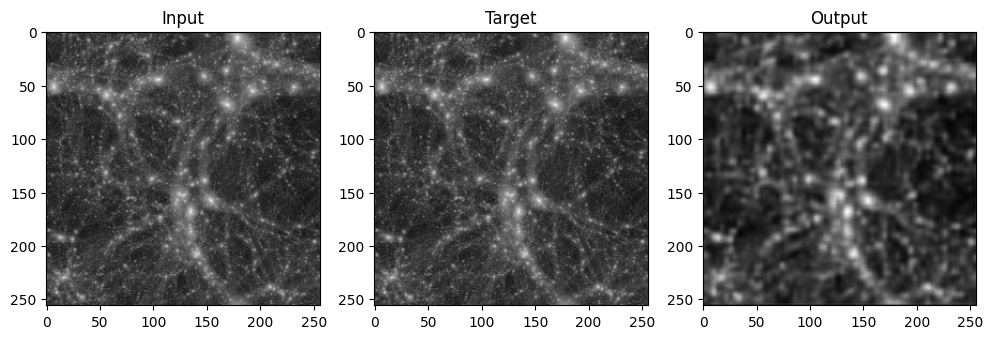

In [11]:
# Testing & visualization
UNetReLU_model_1.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = UNetReLU_model_1(inputs)
        input_img, target_img, output_img = inputs[0, 0].cpu().numpy(), targets[0, 0].cpu().numpy(), outputs[0, 0].cpu().numpy()
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1); plt.title("Input"); plt.imshow(input_img, cmap='binary_r')
        plt.subplot(1, 3, 2); plt.title("Target"); plt.imshow(target_img, cmap='binary_r')
        plt.subplot(1, 3, 3); plt.title("Output"); plt.imshow(output_img, cmap='binary_r')
        plt.savefig('simple_10_epoch_image.png')
        plt.show()
        break

In [12]:
# Function to calculate Peak Signal to Noise Ratio
def calculate_psnr(pred, target):
    mse = nn.functional.mse_loss(pred, target, reduction='mean')
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse + 1e-8))
    return psnr.item()

In [13]:
# Model Evaluation with RMSE and PSNR Metrics
# --------------------------------------------------
# Set model to evaluation mode (disables dropout/batch norm behaviors)
UNetReLU_model_1.eval()

# Initialize metric accumulators
total_mse = 0.0    # Accumulates mean squared errors
total_psnr = 0.0   # Accumulates PSNR values
num_batches = 0    # Tracks number of batches processed

# Disable gradient computation for evaluation
with torch.no_grad():
    # Iterate through test dataset in batches
    for inputs, targets in test_loader:
        # Move data to target device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass: generate model predictions
        predictions = UNetReLU_model_1(inputs)
        
        # Compute Mean Squared Error (MSE) between predictions and targets
        mse = criterion(predictions, targets)
        
        # Compute Peak Signal-to-Noise Ratio (PSNR) 
        # Note: Assumes calculate_psnr() handles:
        # - Input tensor scaling (typically [0,1] or [0,255])
        # - Numerical stability for near-zero MSE cases
        psnr = calculate_psnr(predictions, targets)
        
        # Accumulate metrics across batches
        total_mse += mse.item()  # Extract Python float from tensor
        total_psnr += psnr
        num_batches += 1

# Calculate final metrics by averaging across all batches
# Root Mean Squared Error (RMSE) provides error in input units
rmse = np.sqrt(total_mse / num_batches)

# Average PSNR provides perceptual quality measure in decibels
avg_psnr = total_psnr / num_batches

# Print formatted results
# RMSE formatted to 4 decimal places for precision
# PSNR formatted to 2 decimal places (standard for dB units)
print(f"Test RMSE: {rmse:.4f}")          # Lower is better (0 = perfect)
print(f"Test PSNR: {avg_psnr:.2f} dB")    # Higher is better (∞ = perfect)

Test RMSE: 0.0523
Test PSNR: 25.64 dB


# Training it for 20 epochs

In [14]:
# Initialize model, loss, and optimizer
UNetReLU_model_2 = UNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(UNetReLU_model_2.parameters(), lr=1e-4)

# Track losses
train_losses = []
val_losses = []

# Training loop for 20 epochs
for epoch in range(20):
    # ---- Training Phase ----
    UNetReLU_model_2.train()
    total_train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = UNetReLU_model_2(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---- Validation Phase ----
    UNetReLU_model_2.eval()
    total_val_loss = 0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = UNetReLU_model_2(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

Epoch 1 - Train Loss: 0.0549 - Val Loss: 0.0225
Epoch 2 - Train Loss: 0.0093 - Val Loss: 0.0063
Epoch 3 - Train Loss: 0.0056 - Val Loss: 0.0049
Epoch 4 - Train Loss: 0.0045 - Val Loss: 0.0042
Epoch 5 - Train Loss: 0.0040 - Val Loss: 0.0038
Epoch 6 - Train Loss: 0.0036 - Val Loss: 0.0034
Epoch 7 - Train Loss: 0.0032 - Val Loss: 0.0029
Epoch 8 - Train Loss: 0.0027 - Val Loss: 0.0026
Epoch 9 - Train Loss: 0.0025 - Val Loss: 0.0023
Epoch 10 - Train Loss: 0.0022 - Val Loss: 0.0021
Epoch 11 - Train Loss: 0.0020 - Val Loss: 0.0019
Epoch 12 - Train Loss: 0.0019 - Val Loss: 0.0018
Epoch 13 - Train Loss: 0.0017 - Val Loss: 0.0017
Epoch 14 - Train Loss: 0.0016 - Val Loss: 0.0016
Epoch 15 - Train Loss: 0.0016 - Val Loss: 0.0015
Epoch 16 - Train Loss: 0.0015 - Val Loss: 0.0015
Epoch 17 - Train Loss: 0.0014 - Val Loss: 0.0014
Epoch 18 - Train Loss: 0.0014 - Val Loss: 0.0014
Epoch 19 - Train Loss: 0.0014 - Val Loss: 0.0013
Epoch 20 - Train Loss: 0.0013 - Val Loss: 0.0013


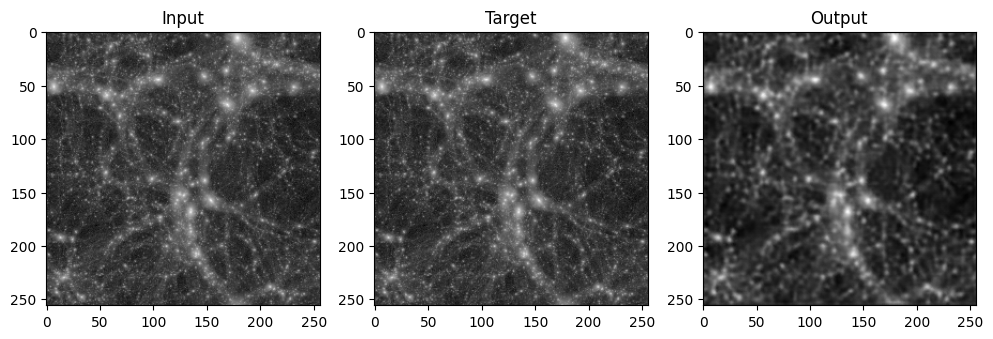

In [15]:
# Testing & visualization
UNetReLU_model_2.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = UNetReLU_model_2(inputs)
        input_img, target_img, output_img = inputs[0, 0].cpu().numpy(), targets[0, 0].cpu().numpy(), outputs[0, 0].cpu().numpy()
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1); plt.title("Input"); plt.imshow(input_img, cmap='binary_r')
        plt.subplot(1, 3, 2); plt.title("Target"); plt.imshow(target_img, cmap='binary_r')
        plt.subplot(1, 3, 3); plt.title("Output"); plt.imshow(output_img, cmap='binary_r')
        plt.savefig('20_epochs_image.png')
        plt.show()
        break

In [16]:
# Compute RMSE and PSNR
UNetReLU_model_2.eval()
total_mse = 0
total_psnr = 0
num_batches = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        predictions = UNetReLU_model_2(inputs)
        mse = criterion(predictions, targets)
        psnr = calculate_psnr(predictions, targets)

        total_mse += mse.item()
        total_psnr += psnr
        num_batches += 1

rmse = np.sqrt(total_mse / num_batches)
avg_psnr = total_psnr / num_batches

print(f"Test RMSE: {rmse:.4f}")
print(f"Test PSNR: {avg_psnr:.2f} dB")

Test RMSE: 0.0458
Test PSNR: 26.78 dB


# Increased Kernel Size from 3 to 5, over 10 epochs

In [17]:
class UNet(nn.Module):
    """Enhanced UNet architecture with larger receptive fields through 5x5 kernels.
    
    This implementation modifies the standard UNet architecture by using 5x5 kernels
    throughout the network, which increases the receptive field at each layer while
    maintaining spatial dimensions through appropriate padding. The architecture
    maintains the classic encoder-bottleneck-decoder structure.

    Key modifications from standard UNet:
        - All convolutional layers use 5x5 kernels instead of 3x3
        - Padding adjusted to maintain spatial dimensions (padding=2 for 5x5 kernels)
        - Maintains simple structure without skip connections for clarity

    Architecture:
        Encoder: [Conv5x5 → ReLU → MaxPool] × 2
        Bottleneck: Conv5x5
        Decoder: [ConvTranspose → ReLU] × 2 → OutputConv5x5
    """
    def __init__(self):
        """Initialize the UNet layers with 5x5 kernels throughout."""
        super(UNet, self).__init__()
        
        # Encoder pathway
        # Two downsampling blocks that progressively extract features
        # Each block consists of:
        #   - Conv2d with 5x5 kernel (padding=2 to maintain dimensions)
        #   - ReLU activation
        #   - MaxPool2d with stride=2 (halving spatial dimensions)
        self.encoder = nn.Sequential(
            # First encoding block: 1 channel → 32 channels
            nn.Conv2d(1, 32, kernel_size=5, padding=2),  # Output: (32, H, W)
            nn.ReLU(inplace=True),                       # Note: inplace=True saves memory
            nn.MaxPool2d(2),                             # Output: (32, H/2, W/2)
            
            # Second encoding block: 32 → 64 channels
            nn.Conv2d(32, 64, kernel_size=5, padding=2), # Output: (64, H/2, W/2)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)                              # Output: (64, H/4, W/4)
        )

        # Bottleneck layer
        # Processes the most compressed representation (64 → 128 channels)
        # Maintains spatial dimensions through padding
        self.middle = nn.Conv2d(64, 128, kernel_size=5, padding=2)  # Output: (128, H/4, W/4)

        # Decoder pathway
        # Two upsampling blocks that reconstruct the image
        # Each block uses transposed convolution for learnable upsampling
        self.decoder = nn.Sequential(
            # First upsampling block: 128 → 64 channels, 2x spatial upsampling
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # Output: (64, H/2, W/2)
            nn.ReLU(inplace=True),
            
            # Second upsampling block: 64 → 32 channels, 2x spatial upsampling
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # Output: (32, H, W)
            nn.ReLU(inplace=True),
            
            # Final output layer: 32 → 1 channel with 5x5 convolution
            # Uses sigmoid activation if working with normalized pixel values
            nn.Conv2d(32, 1, kernel_size=5, padding=2)           # Output: (1, H, W)
        )

    def forward(self, x):
        """Forward pass through the UNet architecture.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 1, height, width)
            
        Returns:
            torch.Tensor: Output tensor of shape (batch_size, 1, height, width)
                            with values depending on final activation
        """
        # Contracting path
        x = self.encoder(x)
        
        # Bottleneck processing
        x = self.middle(x)
        
        # Expanding path
        x = self.decoder(x)
        
        return x

In [18]:
# Initialize model, loss, and optimizer
UNetReLU_model_3 = UNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(UNetReLU_model_3.parameters(), lr=1e-4)

# Track losses
train_losses = []
val_losses = []

# Training loop for 10 epochs
for epoch in range(10):
    # ---- Training Phase ----
    UNetReLU_model_3.train()
    total_train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = UNetReLU_model_3(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---- Validation Phase ----
    UNetReLU_model_3.eval()
    total_val_loss = 0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = UNetReLU_model_3(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

Epoch 1 - Train Loss: 0.0436 - Val Loss: 0.0095
Epoch 2 - Train Loss: 0.0092 - Val Loss: 0.0081
Epoch 3 - Train Loss: 0.0073 - Val Loss: 0.0065
Epoch 4 - Train Loss: 0.0059 - Val Loss: 0.0052
Epoch 5 - Train Loss: 0.0046 - Val Loss: 0.0041
Epoch 6 - Train Loss: 0.0038 - Val Loss: 0.0035
Epoch 7 - Train Loss: 0.0033 - Val Loss: 0.0030
Epoch 8 - Train Loss: 0.0028 - Val Loss: 0.0026
Epoch 9 - Train Loss: 0.0025 - Val Loss: 0.0024
Epoch 10 - Train Loss: 0.0023 - Val Loss: 0.0022


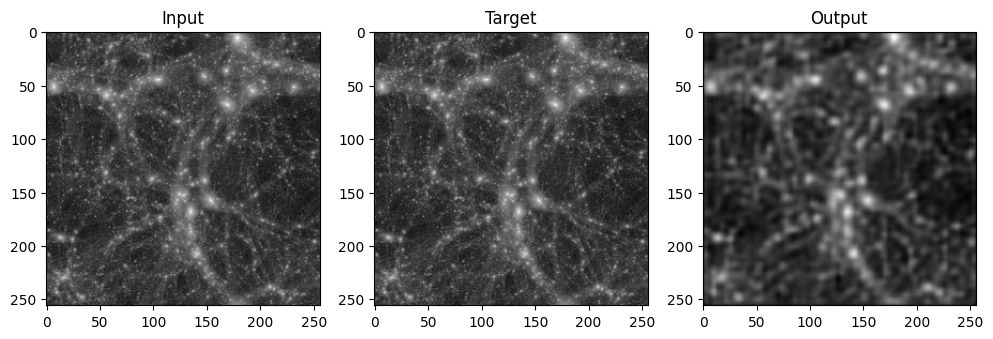

In [19]:
# Testing & visualization
UNetReLU_model_3.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = UNetReLU_model_3(inputs)
        input_img, target_img, output_img = inputs[0, 0].cpu().numpy(), targets[0, 0].cpu().numpy(), outputs[0, 0].cpu().numpy()
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1); plt.title("Input"); plt.imshow(input_img, cmap='binary_r')
        plt.subplot(1, 3, 2); plt.title("Target"); plt.imshow(target_img, cmap='binary_r')
        plt.subplot(1, 3, 3); plt.title("Output"); plt.imshow(output_img, cmap='binary_r')
        plt.savefig('5ks_10_epochs_image.png')
        plt.show()
        break

In [20]:
# Compute RMSE and PSNR
UNetReLU_model_3.eval()
total_mse = 0
total_psnr = 0
num_batches = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        predictions = UNetReLU_model_3(inputs)
        mse = criterion(predictions, targets)
        psnr = calculate_psnr(predictions, targets)

        total_mse += mse.item()
        total_psnr += psnr
        num_batches += 1

rmse = np.sqrt(total_mse / num_batches)
avg_psnr = total_psnr / num_batches

print(f"Test RMSE: {rmse:.4f}")
print(f"Test PSNR: {avg_psnr:.2f} dB")

Test RMSE: 0.0543
Test PSNR: 25.31 dB


# Increased Kernel size from 3 to 5, over 50 epochs

In [21]:
# Initialize model, loss, and optimizer
UNetReLU_model_4 = UNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(UNetReLU_model_4.parameters(), lr=1e-4)

# Track losses
train_losses = []
val_losses = []

# Training loop for 50 epochs
for epoch in range(50):
    # ---- Training Phase ----
    UNetReLU_model_4.train()
    total_train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = UNetReLU_model_4(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---- Validation Phase ----
    UNetReLU_model_4.eval()
    total_val_loss = 0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = UNetReLU_model_4(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

Epoch 1 - Train Loss: 0.0345 - Val Loss: 0.0092
Epoch 2 - Train Loss: 0.0083 - Val Loss: 0.0068
Epoch 3 - Train Loss: 0.0059 - Val Loss: 0.0051
Epoch 4 - Train Loss: 0.0045 - Val Loss: 0.0040
Epoch 5 - Train Loss: 0.0037 - Val Loss: 0.0034
Epoch 6 - Train Loss: 0.0031 - Val Loss: 0.0029
Epoch 7 - Train Loss: 0.0027 - Val Loss: 0.0025
Epoch 8 - Train Loss: 0.0024 - Val Loss: 0.0023
Epoch 9 - Train Loss: 0.0022 - Val Loss: 0.0021
Epoch 10 - Train Loss: 0.0020 - Val Loss: 0.0019
Epoch 11 - Train Loss: 0.0019 - Val Loss: 0.0018
Epoch 12 - Train Loss: 0.0018 - Val Loss: 0.0017
Epoch 13 - Train Loss: 0.0017 - Val Loss: 0.0016
Epoch 14 - Train Loss: 0.0016 - Val Loss: 0.0016
Epoch 15 - Train Loss: 0.0016 - Val Loss: 0.0015
Epoch 16 - Train Loss: 0.0015 - Val Loss: 0.0015
Epoch 17 - Train Loss: 0.0015 - Val Loss: 0.0014
Epoch 18 - Train Loss: 0.0014 - Val Loss: 0.0014
Epoch 19 - Train Loss: 0.0014 - Val Loss: 0.0014
Epoch 20 - Train Loss: 0.0014 - Val Loss: 0.0013
Epoch 21 - Train Loss: 0.0013

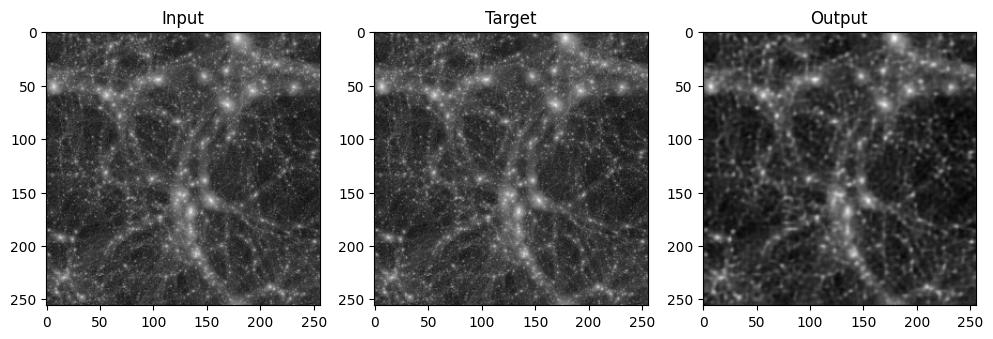

In [22]:
# Testing & visualization
UNetReLU_model_4.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = UNetReLU_model_4(inputs)
        input_img, target_img, output_img = inputs[0, 0].cpu().numpy(), targets[0, 0].cpu().numpy(), outputs[0, 0].cpu().numpy()
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1); plt.title("Input"); plt.imshow(input_img, cmap='binary_r')
        plt.subplot(1, 3, 2); plt.title("Target"); plt.imshow(target_img, cmap='binary_r')
        plt.subplot(1, 3, 3); plt.title("Output"); plt.imshow(output_img, cmap='binary_r')
        plt.savefig('5ks_50_epochs_image.png')
        plt.show()
        break

In [23]:
# Compute RMSE and PSNR
UNetReLU_model_4.eval()
total_mse = 0
total_psnr = 0
num_batches = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        predictions = UNetReLU_model_4(inputs)
        mse = criterion(predictions, targets)
        psnr = calculate_psnr(predictions, targets)

        total_mse += mse.item()
        total_psnr += psnr
        num_batches += 1

rmse = np.sqrt(total_mse / num_batches)
avg_psnr = total_psnr / num_batches

print(f"Test RMSE: {rmse:.4f}")
print(f"Test PSNR: {avg_psnr:.2f} dB")

Test RMSE: 0.0423
Test PSNR: 27.47 dB


# For a 100 epochs

In [24]:
# Initialize model, loss, and optimizer
UNetReLU_model_5 = UNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(UNetReLU_model_5.parameters(), lr=1e-4)

# Track losses
train_losses = []
val_losses = []

# Training loop for 100 epochs
for epoch in range(100):
    # ---- Training Phase ----
    UNetReLU_model_5.train()
    total_train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = UNetReLU_model_5(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---- Validation Phase ----
    UNetReLU_model_5.eval()
    total_val_loss = 0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = UNetReLU_model_5(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

Epoch 1 - Train Loss: 0.0422 - Val Loss: 0.0103
Epoch 2 - Train Loss: 0.0088 - Val Loss: 0.0073
Epoch 3 - Train Loss: 0.0063 - Val Loss: 0.0054
Epoch 4 - Train Loss: 0.0047 - Val Loss: 0.0041
Epoch 5 - Train Loss: 0.0039 - Val Loss: 0.0036
Epoch 6 - Train Loss: 0.0034 - Val Loss: 0.0032
Epoch 7 - Train Loss: 0.0029 - Val Loss: 0.0027
Epoch 8 - Train Loss: 0.0026 - Val Loss: 0.0025
Epoch 9 - Train Loss: 0.0024 - Val Loss: 0.0023
Epoch 10 - Train Loss: 0.0023 - Val Loss: 0.0022
Epoch 11 - Train Loss: 0.0021 - Val Loss: 0.0021
Epoch 12 - Train Loss: 0.0020 - Val Loss: 0.0020
Epoch 13 - Train Loss: 0.0020 - Val Loss: 0.0019
Epoch 14 - Train Loss: 0.0019 - Val Loss: 0.0019
Epoch 15 - Train Loss: 0.0018 - Val Loss: 0.0018
Epoch 16 - Train Loss: 0.0018 - Val Loss: 0.0018
Epoch 17 - Train Loss: 0.0018 - Val Loss: 0.0017
Epoch 18 - Train Loss: 0.0017 - Val Loss: 0.0017
Epoch 19 - Train Loss: 0.0017 - Val Loss: 0.0016
Epoch 20 - Train Loss: 0.0016 - Val Loss: 0.0016
Epoch 21 - Train Loss: 0.0016

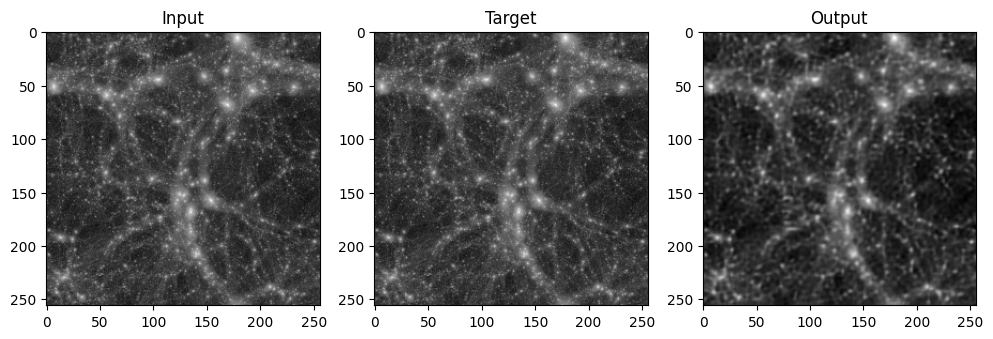

In [25]:
# Testing & visualization
UNetReLU_model_5.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = UNetReLU_model_5(inputs)
        input_img, target_img, output_img = inputs[0, 0].cpu().numpy(), targets[0, 0].cpu().numpy(), outputs[0, 0].cpu().numpy()
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1); plt.title("Input"); plt.imshow(input_img, cmap='binary_r')
        plt.subplot(1, 3, 2); plt.title("Target"); plt.imshow(target_img, cmap='binary_r')
        plt.subplot(1, 3, 3); plt.title("Output"); plt.imshow(output_img, cmap='binary_r')
        plt.savefig('5ks_100_epochs_image.png')
        plt.show()
        break

In [26]:
# Compute RMSE and PSNR
UNetReLU_model_5.eval()
total_mse = 0
total_psnr = 0
num_batches = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        predictions = UNetReLU_model_5(inputs)
        mse = criterion(predictions, targets)
        psnr = calculate_psnr(predictions, targets)

        total_mse += mse.item()
        total_psnr += psnr
        num_batches += 1

rmse = np.sqrt(total_mse / num_batches)
avg_psnr = total_psnr / num_batches

print(f"Test RMSE: {rmse:.4f}")
print(f"Test PSNR: {avg_psnr:.2f} dB")

Test RMSE: 0.0415
Test PSNR: 27.63 dB


# Using LeakyRELU instead of RELU

In [27]:
class UNet(nn.Module):
    """UNet variant with LeakyReLU activations for improved gradient flow.
    
    This implementation features:
        - 5x5 convolutions throughout for larger receptive fields
        - LeakyReLU activations (α=0.01) to prevent dying neurons
        - MaxPooling for downsampling in encoder
        - Transposed convolutions for upsampling in decoder
        - Symmetric architecture with consistent padding

    Architecture Details:
        Encoder: [Conv5x5 → LeakyReLU → MaxPool] × 2
        Bottleneck: Conv5x5 (no activation)
        Decoder: [ConvTranspose → LeakyReLU] × 2 → OutputConv5x5
    """

    def __init__(self):
        """Initialize UNet layers with LeakyReLU activations."""
        super(UNet, self).__init__()

        # Encoder Pathway - Feature Extraction
        # Each block reduces spatial dimensions by 2× while increasing channel depth
        # LeakyReLU's small negative slope (0.01) helps maintain gradient flow
        self.encoder = nn.Sequential(
            # Block 1: 1 → 32 channels
            nn.Conv2d(1, 32, kernel_size=5, padding=2),  # Maintains H,W
            nn.LeakyReLU(negative_slope=0.01, inplace=True),  # Memory efficient
            nn.MaxPool2d(kernel_size=2),  # Halves spatial dimensions
            
            # Block 2: 32 → 64 channels
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d(kernel_size=2)  # Output: (64, H/4, W/4)
        )

        # Bottleneck Layer - High-dimensional processing
        # Processes compressed features at 1/4 original resolution
        # No activation to allow maximum feature representation
        self.middle = nn.Conv2d(
            in_channels=64,
            out_channels=128, 
            kernel_size=5,
            padding=2  # Output: (128, H/4, W/4)
        )

        # Decoder Pathway - Feature Reconstruction
        # Each block increases spatial dimensions by 2× while reducing channels
        # Maintains consistent activation pattern with encoder
        self.decoder = nn.Sequential(
            # Block 1: 128 → 64 channels
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # Doubles H,W
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            
            # Block 2: 64 → 32 channels
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # Original H,W
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            
            # Output Layer: 32 → 1 channel
            # No activation to allow for flexible output scaling
            nn.Conv2d(32, 1, kernel_size=5, padding=2)  # Maintains H,W
        )

    def forward(self, x):
        """Forward pass through the UNet architecture.
        
        Args:
            x (Tensor): Input tensor of shape (B, 1, H, W)
            
        Returns:
            Tensor: Output tensor of shape (B, 1, H, W)
        """
        # Contracting path
        x = self.encoder(x)  # Extract hierarchical features
        
        # Bottleneck processing
        x = self.middle(x)  # High-level feature representation
        
        # Expanding path
        x = self.decoder(x)  # Spatial reconstruction
        
        return x

In [28]:
# Initialize model, loss, and optimizer
UNetLeakyReLU_model_1 = UNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(UNetLeakyReLU_model_1.parameters(), lr=1e-4)

# Track losses
train_losses = []
val_losses = []

# Training loop for 50 epochs
for epoch in range(50):
    # ---- Training Phase ----
    UNetLeakyReLU_model_1.train()
    total_train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = UNetLeakyReLU_model_1(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---- Validation Phase ----
    UNetLeakyReLU_model_1.eval()
    total_val_loss = 0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = UNetLeakyReLU_model_1(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

Epoch 1 - Train Loss: 0.0317 - Val Loss: 0.0104
Epoch 2 - Train Loss: 0.0087 - Val Loss: 0.0075
Epoch 3 - Train Loss: 0.0066 - Val Loss: 0.0059
Epoch 4 - Train Loss: 0.0055 - Val Loss: 0.0050
Epoch 5 - Train Loss: 0.0045 - Val Loss: 0.0041
Epoch 6 - Train Loss: 0.0038 - Val Loss: 0.0036
Epoch 7 - Train Loss: 0.0034 - Val Loss: 0.0032
Epoch 8 - Train Loss: 0.0030 - Val Loss: 0.0028
Epoch 9 - Train Loss: 0.0027 - Val Loss: 0.0026
Epoch 10 - Train Loss: 0.0025 - Val Loss: 0.0024
Epoch 11 - Train Loss: 0.0023 - Val Loss: 0.0022
Epoch 12 - Train Loss: 0.0022 - Val Loss: 0.0021
Epoch 13 - Train Loss: 0.0021 - Val Loss: 0.0020
Epoch 14 - Train Loss: 0.0020 - Val Loss: 0.0019
Epoch 15 - Train Loss: 0.0019 - Val Loss: 0.0019
Epoch 16 - Train Loss: 0.0018 - Val Loss: 0.0018
Epoch 17 - Train Loss: 0.0018 - Val Loss: 0.0018
Epoch 18 - Train Loss: 0.0018 - Val Loss: 0.0017
Epoch 19 - Train Loss: 0.0017 - Val Loss: 0.0017
Epoch 20 - Train Loss: 0.0017 - Val Loss: 0.0016
Epoch 21 - Train Loss: 0.0016

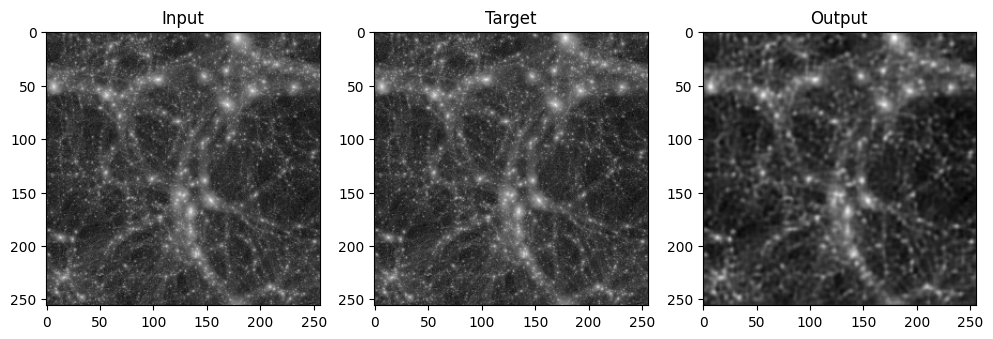

In [29]:
# Visualize results
UNetLeakyReLU_model_1.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = UNetLeakyReLU_model_1(inputs)
        input_img, target_img, output_img = inputs[0, 0].cpu().numpy(), targets[0, 0].cpu().numpy(), outputs[0, 0].cpu().numpy()
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1); plt.title("Input"); plt.imshow(input_img, cmap='binary_r')
        plt.subplot(1, 3, 2); plt.title("Target"); plt.imshow(target_img, cmap='binary_r')
        plt.subplot(1, 3, 3); plt.title("Output"); plt.imshow(output_img, cmap='binary_r')
        plt.savefig('leaky_30_epochs_image.png')
        plt.show()
        break

In [30]:
# Compute RMSE and PSNR
UNetLeakyReLU_model_1.eval()
total_mse = 0
total_psnr = 0
num_batches = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        predictions = UNetLeakyReLU_model_1(inputs)
        mse = criterion(predictions, targets)
        psnr = calculate_psnr(predictions, targets)

        total_mse += mse.item()
        total_psnr += psnr
        num_batches += 1

rmse = np.sqrt(total_mse / num_batches)
avg_psnr = total_psnr / num_batches

print(f"Test RMSE: {rmse:.4f}")
print(f"Test PSNR: {avg_psnr:.2f} dB")

Test RMSE: 0.0443
Test PSNR: 27.06 dB


# For a 100 epochs

In [31]:
# Initialize model, loss, and optimizer
UNetLeakyReLU_model_2 = UNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(UNetLeakyReLU_model_2.parameters(), lr=1e-4)

# Track losses
train_losses = []
val_losses = []

# Training loop for 100 epochs
for epoch in range(100):
    # ---- Training Phase ----
    UNetLeakyReLU_model_2.train()
    total_train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = UNetLeakyReLU_model_2(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---- Validation Phase ----
    UNetLeakyReLU_model_2.eval()
    total_val_loss = 0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = UNetLeakyReLU_model_2(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

Epoch 1 - Train Loss: 0.0433 - Val Loss: 0.0095
Epoch 2 - Train Loss: 0.0090 - Val Loss: 0.0079
Epoch 3 - Train Loss: 0.0071 - Val Loss: 0.0063
Epoch 4 - Train Loss: 0.0058 - Val Loss: 0.0053
Epoch 5 - Train Loss: 0.0048 - Val Loss: 0.0043
Epoch 6 - Train Loss: 0.0041 - Val Loss: 0.0038
Epoch 7 - Train Loss: 0.0037 - Val Loss: 0.0035
Epoch 8 - Train Loss: 0.0033 - Val Loss: 0.0031
Epoch 9 - Train Loss: 0.0029 - Val Loss: 0.0028
Epoch 10 - Train Loss: 0.0027 - Val Loss: 0.0025
Epoch 11 - Train Loss: 0.0025 - Val Loss: 0.0024
Epoch 12 - Train Loss: 0.0023 - Val Loss: 0.0022
Epoch 13 - Train Loss: 0.0022 - Val Loss: 0.0021
Epoch 14 - Train Loss: 0.0021 - Val Loss: 0.0020
Epoch 15 - Train Loss: 0.0020 - Val Loss: 0.0019
Epoch 16 - Train Loss: 0.0019 - Val Loss: 0.0019
Epoch 17 - Train Loss: 0.0018 - Val Loss: 0.0018
Epoch 18 - Train Loss: 0.0018 - Val Loss: 0.0018
Epoch 19 - Train Loss: 0.0017 - Val Loss: 0.0017
Epoch 20 - Train Loss: 0.0017 - Val Loss: 0.0017
Epoch 21 - Train Loss: 0.0016

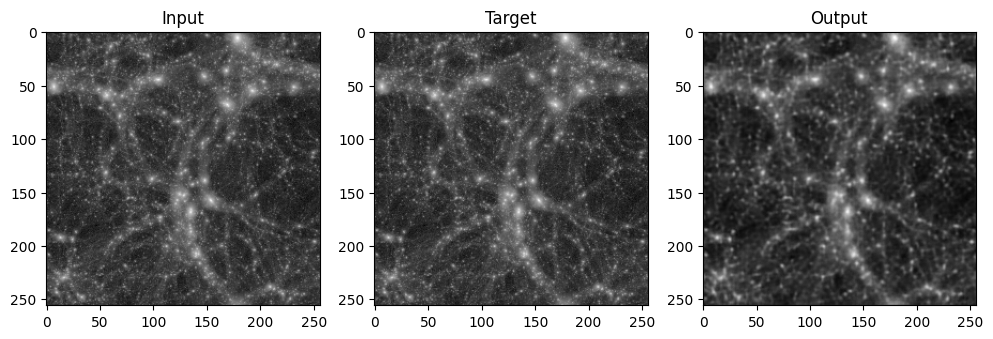

In [32]:
# Visualize results
UNetLeakyReLU_model_2.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = UNetLeakyReLU_model_2(inputs)
        input_img, target_img, output_img = inputs[0, 0].cpu().numpy(), targets[0, 0].cpu().numpy(), outputs[0, 0].cpu().numpy()
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1); plt.title("Input"); plt.imshow(input_img, cmap='binary_r')
        plt.subplot(1, 3, 2); plt.title("Target"); plt.imshow(target_img, cmap='binary_r')
        plt.subplot(1, 3, 3); plt.title("Output"); plt.imshow(output_img, cmap='binary_r')
        plt.savefig('leaky_100_epochs_image.png')
        plt.show()
        break

In [33]:
# Compute RMSE and PSNR
UNetLeakyReLU_model_2.eval()
total_mse = 0
total_psnr = 0
num_batches = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        predictions = UNetLeakyReLU_model_2(inputs)
        mse = criterion(predictions, targets)
        psnr = calculate_psnr(predictions, targets)

        total_mse += mse.item()
        total_psnr += psnr
        num_batches += 1

rmse = np.sqrt(total_mse / num_batches)
avg_psnr = total_psnr / num_batches

print(f"Test RMSE: {rmse:.4f}")
print(f"Test PSNR: {avg_psnr:.2f} dB")

Test RMSE: 0.0407
Test PSNR: 27.82 dB


# Using a more Deeper Neural Network

In [34]:
class UNet(nn.Module):
    """Enhanced UNet architecture with batch normalization and deeper structure.
    
    This implementation features:
        - Deeper encoder/decoder blocks (2 conv layers per resolution level)
        - Batch normalization after each convolution for stable training
        - LeakyReLU (α=0.01) activations for improved gradient flow
        - 5x5 kernels throughout for larger receptive fields
        - Symmetric encoder-decoder structure with bottleneck
        
    Architecture:
        Encoder: [Conv→BN→LReLU→Conv→BN→LReLU→MaxPool] × 2
        Middle: [Conv→BN→LReLU→Conv→BN→LReLU] (no pooling)
        Decoder: [ConvTranspose→BN→LReLU→Conv→BN→LReLU] × 2
        Final: Conv5x5 (no activation)
    """

    def __init__(self):
        """Initialize UNet with batch normalization and deeper blocks."""
        super(UNet, self).__init__()

        # Encoder Pathway - Feature Extraction
        # Each encoder block contains two convolutional layers before downsampling
        # Channel progression: 1 → 64 → 128 → 256 (bottleneck)
        
        # First encoder block (1/2 resolution)
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, padding=2),  # Output: (64, H, W)
            nn.BatchNorm2d(64),  # Normalizes activations along channel dimension
            nn.LeakyReLU(0.01, inplace=True),  # Parametric ReLU with small negative slope
            nn.Conv2d(64, 64, kernel_size=5, padding=2),  # Output: (64, H, W)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01, inplace=True),
            nn.MaxPool2d(2)  # Output: (64, H/2, W/2)
        )

        # Second encoder block (1/4 resolution)
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, padding=2),  # Output: (128, H/2, W/2)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Conv2d(128, 128, kernel_size=5, padding=2),  # Output: (128, H/2, W/2)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01, inplace=True),
            nn.MaxPool2d(2)  # Output: (128, H/4, W/4)
        )

        # Bottleneck (1/4 resolution - deepest features)
        self.middle = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=5, padding=2),  # Output: (256, H/4, W/4)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Conv2d(256, 256, kernel_size=5, padding=2),  # Output: (256, H/4, W/4)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.01, inplace=True)
        )

        # Decoder Pathway - Feature Reconstruction
        # Each decoder block upsamples then processes features
        # Channel progression: 256 → 128 → 64 → 1 (output)

        # First decoder block (1/2 resolution)
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),  # Output: (128, H/2, W/2)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Conv2d(128, 128, kernel_size=5, padding=2),  # Output: (128, H/2, W/2)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01, inplace=True)
        )

        # Second decoder block (full resolution)
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # Output: (64, H, W)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),  # Output: (64, H, W)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01, inplace=True)
        )

        # Final output layer (no activation for flexible output range)
        self.final = nn.Conv2d(64, 1, kernel_size=5, padding=2)  # Output: (1, H, W)

    def forward(self, x):
        """Forward pass through the UNet architecture.
        
        Args:
            x (Tensor): Input tensor of shape (B, 1, H, W)
            
        Returns:
            Tensor: Output tensor of shape (B, 1, H, W)
        """
        # Contracting path
        x1 = self.enc1(x)  # First-level features
        x2 = self.enc2(x1)  # Second-level features
        
        # Bottleneck processing
        x = self.middle(x2)  # Deepest features
        
        # Expanding path (note: skip connections would be added here in full UNet)
        x = self.dec1(x)  # First upsample
        x = self.dec2(x)  # Second upsample
        
        # Final output (no activation)
        return self.final(x)

In [35]:
# Initialize model, loss, and optimizer
UNetDeep_model_1 = UNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(UNetDeep_model_1.parameters(), lr=1e-4)

# Track losses
train_losses = []
val_losses = []

# Training loop for 20 epochs
for epoch in range(20):
    # ---- Training Phase ----
    UNetDeep_model_1.train()
    total_train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = UNetDeep_model_1(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---- Validation Phase ----
    UNetDeep_model_1.eval()
    total_val_loss = 0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = UNetDeep_model_1(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

Epoch 1 - Train Loss: 0.0181 - Val Loss: 0.0153
Epoch 2 - Train Loss: 0.0006 - Val Loss: 0.0011
Epoch 3 - Train Loss: 0.0001 - Val Loss: 0.0000
Epoch 4 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 5 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 6 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 7 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 8 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 9 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 10 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 11 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 12 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 13 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 14 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 15 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 16 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 17 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 18 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 19 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 20 - Train Loss: 0.0000 - Val Loss: 0.0001


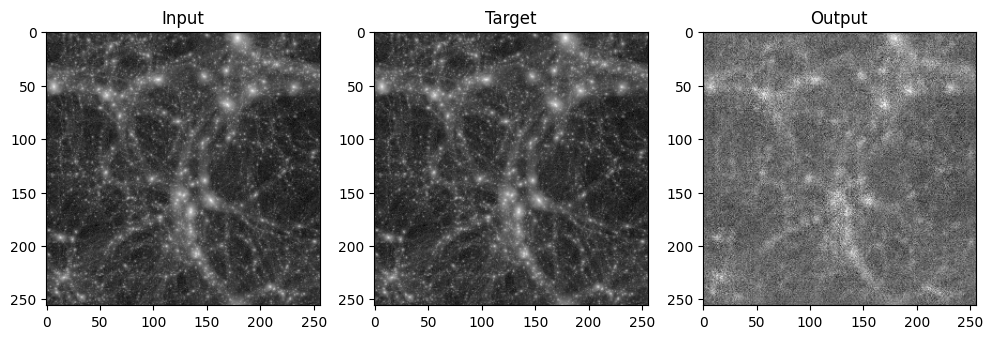

In [36]:
# Visualize results
UNetDeep_model_1.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = UNetDeep_model_1(inputs)
        input_img, target_img, output_img = inputs[0, 0].cpu().numpy(), targets[0, 0].cpu().numpy(), outputs[0, 0].cpu().numpy()
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1); plt.title("Input"); plt.imshow(input_img, cmap='binary_r')
        plt.subplot(1, 3, 2); plt.title("Target"); plt.imshow(target_img, cmap='binary_r')
        plt.subplot(1, 3, 3); plt.title("Output"); plt.imshow(output_img, cmap='binary_r')
        plt.savefig('super_100_epochs_image.png')
        plt.show()
        break

In [37]:
# Compute RMSE and PSNR
UNetDeep_model_1.eval()
total_mse = 0
total_psnr = 0
num_batches = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        predictions = UNetDeep_model_1(inputs)
        mse = criterion(predictions, targets)
        psnr = calculate_psnr(predictions, targets)

        total_mse += mse.item()
        total_psnr += psnr
        num_batches += 1

rmse = np.sqrt(total_mse / num_batches)
avg_psnr = total_psnr / num_batches

print(f"Test RMSE: {rmse:.4f}")
print(f"Test PSNR: {avg_psnr:.2f} dB")

Test RMSE: 0.1124
Test PSNR: 18.99 dB


# Adding a Dropout to prevent over-smoothing

In [38]:
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.dropout = nn.Dropout2d(p=0.2)  # 2D dropout for feature maps

        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 64, 5, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),
            nn.Dropout2d(0.2),

            nn.Conv2d(64, 64, 5, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),
            nn.Dropout2d(0.2),

            nn.MaxPool2d(2)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 5, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01),
            nn.Dropout2d(0.2),

            nn.Conv2d(128, 128, 5, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01),
            nn.Dropout2d(0.2),

            nn.MaxPool2d(2)
        )

        # Middle
        self.middle = nn.Sequential(
            nn.Conv2d(128, 256, 5, padding=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.01),
            nn.Dropout2d(0.2),

            nn.Conv2d(256, 256, 5, padding=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.01),
            nn.Dropout2d(0.2)
        )

        # Decoder
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 2, stride=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01),

            nn.Conv2d(128, 128, 5, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01)
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),

            nn.Conv2d(64, 64, 5, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01)
        )

        # Output
        self.final = nn.Conv2d(64, 1, 5, padding=2)

    def forward(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        x = self.middle(x)
        x = self.dec1(x)
        x = self.dec2(x)
        x = self.final(x)
        return x


In [39]:
# Initialize model, loss, and optimizer
UNetDeep_model_2 = UNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(UNetDeep_model_2.parameters(), lr=1e-4)

# Track losses
train_losses = []
val_losses = []

# Training loop for 50 epochs
for epoch in range(50):
    # ---- Training Phase ----
    UNetDeep_model_2.train()
    total_train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = UNetDeep_model_2(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---- Validation Phase ----
    UNetDeep_model_2.eval()
    total_val_loss = 0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = UNetDeep_model_2(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

Epoch 1 - Train Loss: 0.0274 - Val Loss: 0.0102
Epoch 2 - Train Loss: 0.0054 - Val Loss: 0.0039
Epoch 3 - Train Loss: 0.0043 - Val Loss: 0.0031
Epoch 4 - Train Loss: 0.0036 - Val Loss: 0.0028
Epoch 5 - Train Loss: 0.0033 - Val Loss: 0.0025
Epoch 6 - Train Loss: 0.0030 - Val Loss: 0.0023
Epoch 7 - Train Loss: 0.0028 - Val Loss: 0.0025
Epoch 8 - Train Loss: 0.0026 - Val Loss: 0.0021
Epoch 9 - Train Loss: 0.0025 - Val Loss: 0.0019
Epoch 10 - Train Loss: 0.0024 - Val Loss: 0.0022
Epoch 11 - Train Loss: 0.0023 - Val Loss: 0.0017
Epoch 12 - Train Loss: 0.0021 - Val Loss: 0.0017
Epoch 13 - Train Loss: 0.0020 - Val Loss: 0.0016
Epoch 14 - Train Loss: 0.0020 - Val Loss: 0.0015
Epoch 15 - Train Loss: 0.0019 - Val Loss: 0.0014
Epoch 16 - Train Loss: 0.0018 - Val Loss: 0.0014
Epoch 17 - Train Loss: 0.0018 - Val Loss: 0.0014
Epoch 18 - Train Loss: 0.0018 - Val Loss: 0.0014
Epoch 19 - Train Loss: 0.0017 - Val Loss: 0.0013
Epoch 20 - Train Loss: 0.0017 - Val Loss: 0.0012
Epoch 21 - Train Loss: 0.0016

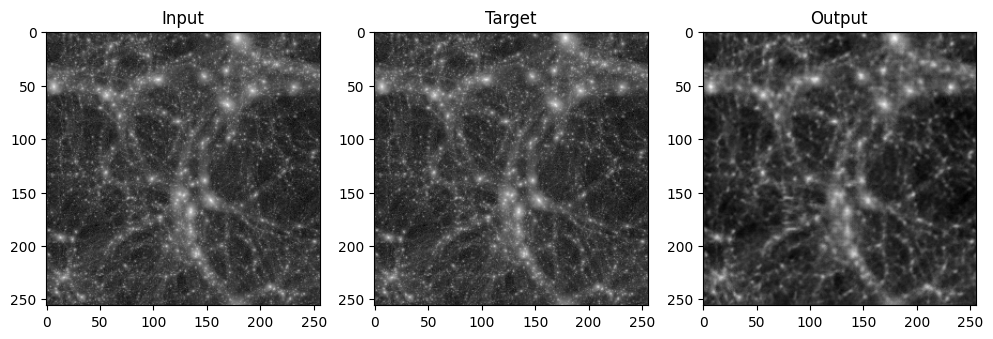

In [40]:
# Visualize results
UNetDeep_model_2.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = UNetDeep_model_2(inputs)
        input_img, target_img, output_img = inputs[0, 0].cpu().numpy(), targets[0, 0].cpu().numpy(), outputs[0, 0].cpu().numpy()
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1); plt.title("Input"); plt.imshow(input_img, cmap='binary_r')
        plt.subplot(1, 3, 2); plt.title("Target"); plt.imshow(target_img, cmap='binary_r')
        plt.subplot(1, 3, 3); plt.title("Output"); plt.imshow(output_img, cmap='binary_r')
        plt.savefig('super_do_10_epochs_image.png')
        plt.show()
        break

In [41]:
# Compute RMSE and PSNR
UNetDeep_model_2.eval()
total_mse = 0
total_psnr = 0
num_batches = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        predictions = UNetDeep_model_2(inputs)
        mse = criterion(predictions, targets)
        psnr = calculate_psnr(predictions, targets)

        total_mse += mse.item()
        total_psnr += psnr
        num_batches += 1

rmse = np.sqrt(total_mse / num_batches)
avg_psnr = total_psnr / num_batches

print(f"Test RMSE: {rmse:.4f}")
print(f"Test PSNR: {avg_psnr:.2f} dB")

Test RMSE: 0.0474
Test PSNR: 26.48 dB


# Using a ResNet style Autoencoder

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    """Residual block with identity mapping and optional downsampling.
    
    Implements the standard residual block architecture from:
    "Deep Residual Learning for Image Recognition" (He et al., 2016)
    with added LeakyReLU activation and batch normalization.
    
    Key features:
        - Two 3x3 convolutional layers with batch norm
        - LeakyReLU activation (α=0.01) for gradient flow
        - Optional 1x1 projection shortcut for dimension matching
        - Residual connection preserves gradient flow
    """
    def __init__(self, in_channels, out_channels, stride=1):
        """
        Args:
            in_channels: Input channel dimension
            out_channels: Output channel dimension  
            stride: Stride for first convolution (enables downsampling)
        """
        super().__init__()
        # Check if input/output shapes will match for residual connection
        self.same_shape = (in_channels == out_channels and stride == 1)
        
        # Main convolution path
        self.conv1 = nn.Conv2d(in_channels, out_channels, 
                              kernel_size=3, padding=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(0.01, inplace=True)  # Memory efficient
        self.conv2 = nn.Conv2d(out_channels, out_channels, 
                              kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection for dimension matching
        self.downsample = None
        if not self.same_shape:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 
                         kernel_size=1, stride=stride),  # Projection
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        """Forward pass with residual connection.
        
        Args:
            x: Input tensor of shape (B, in_channels, H, W)
            
        Returns:
            Output tensor of shape (B, out_channels, H', W')
        """
        identity = x  # Save input for residual connection
        
        # Main path
        out = self.act(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        # Shortcut path if dimensions don't match
        if self.downsample is not None:
            identity = self.downsample(x)
            
        # Residual connection
        out += identity
        return self.act(out)  # Final activation


class ResNetAutoencoder(nn.Module):
    """ResNet-based Autoencoder with symmetric encoder-decoder architecture.
    
    Architecture features:
        Encoder:
            - Initial 7x7 convolution with stride 2
            - Max pooling
            - 4 residual blocks with progressive downsampling
        Decoder: 
            - Transposed convolutions for upsampling
            - Residual blocks at each scale
            - Final sigmoid activation for [0,1] output
            
    Input/Output: 256x256 grayscale images
    """
    def __init__(self):
        super().__init__()
        
        # Encoder Pathway (256x256 → 16x16)
        self.encoder = nn.Sequential(
            # Initial downsampling (256→128)
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01, inplace=True),
            nn.MaxPool2d(2),  # 128→64
            
            # Residual blocks with progressive downsampling
            ResidualBlock(64, 128, stride=2),  # 64→32
            ResidualBlock(128, 128),            # 32→32
            
            ResidualBlock(128, 256, stride=2),  # 32→16
            ResidualBlock(256, 256)             # 16→16
        )
        
        # Decoder Pathway (16x16 → 256x256)
        self.decoder = nn.Sequential(
            # First upsampling (16→32)
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.LeakyReLU(0.01, inplace=True),
            ResidualBlock(128, 128),
            
            # Second upsampling (32→64)
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.LeakyReLU(0.01, inplace=True),
            ResidualBlock(64, 64),
            
            # Third upsampling (64→128)
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.LeakyReLU(0.01, inplace=True),
            
            # Final upsampling (128→256) with sigmoid activation
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),
            nn.Sigmoid()  # Constrain output to [0,1] range
        )

    def forward(self, x):
        """Autoencoder forward pass.
        
        Args:
            x: Input tensor of shape (B, 1, 256, 256)
            
        Returns:
            Reconstructed tensor of shape (B, 1, 256, 256)
        """
        # Encode to latent space
        x = self.encoder(x)
        
        # Decode back to input space
        x = self.decoder(x)
        
        return x

In [43]:
# Initialize model, loss, and optimizer
ResNet_model_1 = ResNetAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ResNet_model_1.parameters(), lr=1e-4)

# Track losses
train_losses = []
val_losses = []

# Training loop for 50 epochs
for epoch in range(50):
    # ---- Training Phase ----
    ResNet_model_1.train()
    total_train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = ResNet_model_1(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---- Validation Phase ----
    ResNet_model_1.eval()
    total_val_loss = 0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = ResNet_model_1(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

Epoch 1 - Train Loss: 0.0519 - Val Loss: 0.0278
Epoch 2 - Train Loss: 0.0135 - Val Loss: 0.0051
Epoch 3 - Train Loss: 0.0038 - Val Loss: 0.0032
Epoch 4 - Train Loss: 0.0026 - Val Loss: 0.0024
Epoch 5 - Train Loss: 0.0021 - Val Loss: 0.0019
Epoch 6 - Train Loss: 0.0017 - Val Loss: 0.0015
Epoch 7 - Train Loss: 0.0014 - Val Loss: 0.0013
Epoch 8 - Train Loss: 0.0012 - Val Loss: 0.0011
Epoch 9 - Train Loss: 0.0010 - Val Loss: 0.0009
Epoch 10 - Train Loss: 0.0008 - Val Loss: 0.0008
Epoch 11 - Train Loss: 0.0007 - Val Loss: 0.0007
Epoch 12 - Train Loss: 0.0006 - Val Loss: 0.0006
Epoch 13 - Train Loss: 0.0005 - Val Loss: 0.0005
Epoch 14 - Train Loss: 0.0004 - Val Loss: 0.0005
Epoch 15 - Train Loss: 0.0004 - Val Loss: 0.0004
Epoch 16 - Train Loss: 0.0003 - Val Loss: 0.0003
Epoch 17 - Train Loss: 0.0003 - Val Loss: 0.0003
Epoch 18 - Train Loss: 0.0002 - Val Loss: 0.0002
Epoch 19 - Train Loss: 0.0002 - Val Loss: 0.0002
Epoch 20 - Train Loss: 0.0002 - Val Loss: 0.0002
Epoch 21 - Train Loss: 0.0002

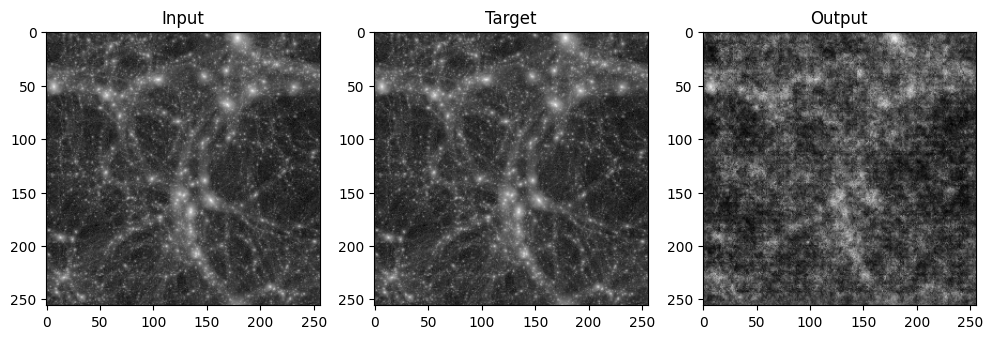

In [44]:
# Visualize results
ResNet_model_1.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = ResNet_model_1(inputs)
        input_img, target_img, output_img = inputs[0, 0].cpu().numpy(), targets[0, 0].cpu().numpy(), outputs[0, 0].cpu().numpy()
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1); plt.title("Input"); plt.imshow(input_img, cmap='binary_r')
        plt.subplot(1, 3, 2); plt.title("Target"); plt.imshow(target_img, cmap='binary_r')
        plt.subplot(1, 3, 3); plt.title("Output"); plt.imshow(output_img, cmap='binary_r')
        plt.savefig('resnet_10_epochs_image.png')
        plt.show()
        break

In [45]:
# Compute RMSE and PSNR
ResNet_model_1.eval()
total_mse = 0
total_psnr = 0
num_batches = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        predictions = ResNet_model_1(inputs)
        mse = criterion(predictions, targets)
        psnr = calculate_psnr(predictions, targets)

        total_mse += mse.item()
        total_psnr += psnr
        num_batches += 1

rmse = np.sqrt(total_mse / num_batches)
avg_psnr = total_psnr / num_batches

print(f"Test RMSE: {rmse:.4f}")
print(f"Test PSNR: {avg_psnr:.2f} dB")

Test RMSE: 0.0939
Test PSNR: 20.55 dB


# Using a 2D style V-Net Architecture

In [46]:
import torch
import torch.nn as nn

class VNet2D(nn.Module):
    """Simplified 2D V-Net architecture for image-to-image tasks.
    
    Consists of:
        - Encoder with two downsampling blocks
        - Bottleneck feature extraction
        - Decoder with skip connections and upsampling
        - Final 1x1 convolution to restore original channel count
    
    Assumes input is a single-channel 2D image (e.g., grayscale).
    """
    def __init__(self):
        super(VNet2D, self).__init__()

        def conv_block(in_ch, out_ch):
            """Helper function to create a double Conv-BN-ReLU block."""
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )

        # Encoder path (contracting)
        self.down1 = conv_block(1, 32)      # First level conv block
        self.pool1 = nn.MaxPool2d(2)        # Downsample to 1/2 size

        self.down2 = conv_block(32, 64)     # Second level conv block
        self.pool2 = nn.MaxPool2d(2)        # Downsample again

        # Bottleneck
        self.bridge = conv_block(64, 128)   # Deepest features

        # Decoder path (expanding)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # Upsample
        self.dec2 = conv_block(128, 64)  # Skip connection from down2

        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)   # Upsample
        self.dec1 = conv_block(64, 32)   # Skip connection from down1

        # Output layer
        self.final = nn.Conv2d(32, 1, kernel_size=1)  # Restore to 1 channel

    def forward(self, x):
        """Defines the forward pass of the VNet2D.
        
        Args:
            x: Input tensor of shape (B, 1, H, W)
        
        Returns:
            Output tensor of shape (B, 1, H, W)
        """
        # Encoder
        d1 = self.down1(x)        # Level 1 features
        p1 = self.pool1(d1)       # Downsampled

        d2 = self.down2(p1)       # Level 2 features
        p2 = self.pool2(d2)       # Downsampled again

        # Bottleneck
        b = self.bridge(p2)       # Deepest representation

        # Decoder
        u2 = self.up2(b)                          # Upsample
        u2 = torch.cat([u2, d2], dim=1)           # Skip connection
        d2 = self.dec2(u2)                        # Refine features

        u1 = self.up1(d2)                         # Upsample
        u1 = torch.cat([u1, d1], dim=1)           # Skip connection
        d1 = self.dec1(u1)                        # Refine features

        # Output
        out = self.final(d1)                      # Final prediction
        return out

In [47]:
# Initialize model, loss, and optimizer
VNetmodel_1 = VNet2D().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(VNetmodel_1.parameters(), lr=1e-4)

# Track losses
train_losses = []
val_losses = []

# Training loop for 20 epochs
for epoch in range(20):
    # ---- Training Phase ----
    VNetmodel_1.train()
    total_train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = VNetmodel_1(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---- Validation Phase ----
    VNetmodel_1.eval()
    total_val_loss = 0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = VNetmodel_1(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

Epoch 1 - Train Loss: 0.0781 - Val Loss: 0.0140
Epoch 2 - Train Loss: 0.0075 - Val Loss: 0.0036
Epoch 3 - Train Loss: 0.0022 - Val Loss: 0.0018
Epoch 4 - Train Loss: 0.0014 - Val Loss: 0.0013
Epoch 5 - Train Loss: 0.0011 - Val Loss: 0.0010
Epoch 6 - Train Loss: 0.0008 - Val Loss: 0.0008
Epoch 7 - Train Loss: 0.0007 - Val Loss: 0.0007
Epoch 8 - Train Loss: 0.0006 - Val Loss: 0.0006
Epoch 9 - Train Loss: 0.0005 - Val Loss: 0.0005
Epoch 10 - Train Loss: 0.0005 - Val Loss: 0.0004
Epoch 11 - Train Loss: 0.0004 - Val Loss: 0.0004
Epoch 12 - Train Loss: 0.0004 - Val Loss: 0.0004
Epoch 13 - Train Loss: 0.0003 - Val Loss: 0.0003
Epoch 14 - Train Loss: 0.0003 - Val Loss: 0.0003
Epoch 15 - Train Loss: 0.0003 - Val Loss: 0.0003
Epoch 16 - Train Loss: 0.0003 - Val Loss: 0.0003
Epoch 17 - Train Loss: 0.0003 - Val Loss: 0.0002
Epoch 18 - Train Loss: 0.0002 - Val Loss: 0.0002
Epoch 19 - Train Loss: 0.0002 - Val Loss: 0.0002
Epoch 20 - Train Loss: 0.0002 - Val Loss: 0.0002


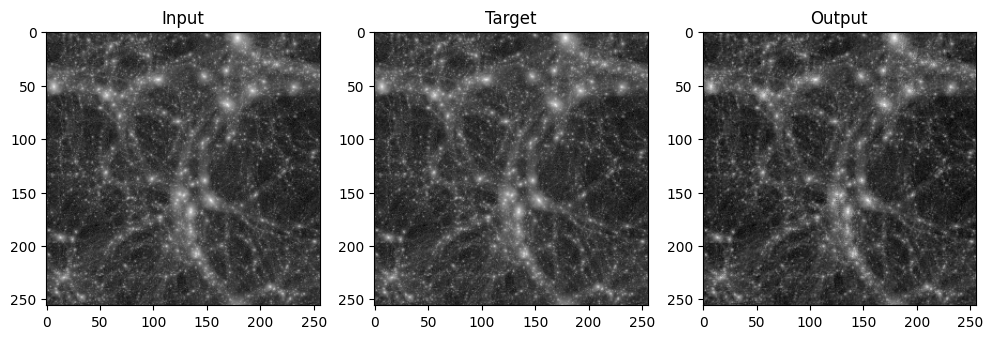

In [48]:
# Visualize results
VNetmodel_1.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = VNetmodel_1(inputs)
        input_img, target_img, output_img = inputs[0, 0].cpu().numpy(), targets[0, 0].cpu().numpy(), outputs[0, 0].cpu().numpy()
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1); plt.title("Input"); plt.imshow(input_img, cmap='binary_r')
        plt.subplot(1, 3, 2); plt.title("Target"); plt.imshow(target_img, cmap='binary_r')
        plt.subplot(1, 3, 3); plt.title("Output"); plt.imshow(output_img, cmap='binary_r')
        plt.savefig('VNet_20_epochs_image.png')
        plt.show()
        break

In [49]:
# Evaluation
VNetmodel_1.eval()
total_mse = 0
total_psnr = 0
num_batches = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        preds = VNetmodel_1(inputs)
        mse = criterion(preds, targets)
        psnr = calculate_psnr(preds, targets)

        total_mse += mse.item()
        total_psnr += psnr
        num_batches += 1

vnet_rmse = np.sqrt(total_mse / num_batches)
vnet_psnr = total_psnr / num_batches

print(f"VNet Test RMSE: {vnet_rmse:.4f}")
print(f"VNet Test PSNR: {vnet_psnr:.2f} dB")

VNet Test RMSE: 0.0217
VNet Test PSNR: 33.28 dB


# For 50 Epochs

In [50]:
# Initialize model, loss, and optimizer
VNetmodel_2 = VNet2D().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(VNetmodel_2.parameters(), lr=1e-4)

# Track losses
train_losses = []
val_losses = []

# Training loop for 50 epochs
for epoch in range(50):
    # ---- Training Phase ----
    VNetmodel_2.train()
    total_train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = VNetmodel_2(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---- Validation Phase ----
    VNetmodel_2.eval()
    total_val_loss = 0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = VNetmodel_2(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

Epoch 1 - Train Loss: 0.1393 - Val Loss: 0.0254
Epoch 2 - Train Loss: 0.0144 - Val Loss: 0.0065
Epoch 3 - Train Loss: 0.0041 - Val Loss: 0.0033
Epoch 4 - Train Loss: 0.0026 - Val Loss: 0.0023
Epoch 5 - Train Loss: 0.0019 - Val Loss: 0.0017
Epoch 6 - Train Loss: 0.0015 - Val Loss: 0.0014
Epoch 7 - Train Loss: 0.0013 - Val Loss: 0.0012
Epoch 8 - Train Loss: 0.0011 - Val Loss: 0.0010
Epoch 9 - Train Loss: 0.0009 - Val Loss: 0.0009
Epoch 10 - Train Loss: 0.0008 - Val Loss: 0.0008
Epoch 11 - Train Loss: 0.0007 - Val Loss: 0.0007
Epoch 12 - Train Loss: 0.0007 - Val Loss: 0.0006
Epoch 13 - Train Loss: 0.0006 - Val Loss: 0.0006
Epoch 14 - Train Loss: 0.0006 - Val Loss: 0.0005
Epoch 15 - Train Loss: 0.0005 - Val Loss: 0.0005
Epoch 16 - Train Loss: 0.0005 - Val Loss: 0.0005
Epoch 17 - Train Loss: 0.0005 - Val Loss: 0.0004
Epoch 18 - Train Loss: 0.0004 - Val Loss: 0.0004
Epoch 19 - Train Loss: 0.0004 - Val Loss: 0.0004
Epoch 20 - Train Loss: 0.0004 - Val Loss: 0.0004
Epoch 21 - Train Loss: 0.0004

In [51]:
# Evaluation
VNetmodel_2.eval()
total_mse = 0
total_psnr = 0
num_batches = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        preds = VNetmodel_2(inputs)
        mse = criterion(preds, targets)
        psnr = calculate_psnr(preds, targets)

        total_mse += mse.item()
        total_psnr += psnr
        num_batches += 1

vnet_rmse = np.sqrt(total_mse / num_batches)
vnet_psnr = total_psnr / num_batches

print(f"VNet Test RMSE: {vnet_rmse:.4f}")
print(f"VNet Test PSNR: {vnet_psnr:.2f} dB")

VNet Test RMSE: 0.0190
VNet Test PSNR: 34.40 dB


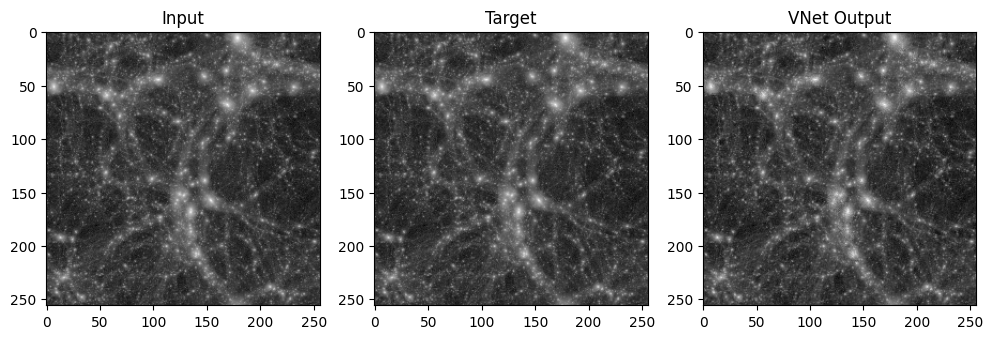

In [52]:
# Evaluation
VNetmodel_2.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        preds = VNetmodel_2(inputs)
        inp, tgt, out = inputs[0, 0].cpu().numpy(), targets[0, 0].cpu().numpy(), preds[0, 0].cpu().numpy()
        
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1); plt.title("Input"); plt.imshow(inp, cmap='binary_r')
        plt.subplot(1, 3, 2); plt.title("Target"); plt.imshow(tgt, cmap='binary_r')
        plt.subplot(1, 3, 3); plt.title("VNet Output"); plt.imshow(out, cmap='binary_r')
        plt.savefig("vnet_output_epoch50.png")
        plt.show()
        break

# Adding skip connections to the Initial UNet Model

In [53]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    """Simplified 2D U-Net architecture with skip connections.
    
    This implementation follows the classical U-Net structure:
    - Encoder: progressively downsamples and increases feature depth
    - Bottleneck: processes compact feature representation
    - Decoder: upsamples and fuses features with skip connections from encoder
    - Output: restores to original spatial resolution with single-channel output
    
    Input/Output shape: (B, 1, 256, 256)
    """
    def __init__(self):
        super(UNet, self).__init__()

        # -------------------------------
        # Encoder Path (Contracting path)
        # -------------------------------

        # Level 1 Encoding: Conv → ReLU
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),  # Maintains 256x256
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2)  # Downsamples to 128x128

        # Level 2 Encoding
        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, padding=2),  # Maintains 128x128
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2)  # Downsamples to 64x64

        # ---------------------
        # Bottleneck Layer
        # ---------------------
        # Intermediate feature transformation (no spatial downsampling)
        self.middle = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, padding=2),  # 64x64 → 64x64
            nn.ReLU(inplace=True)
        )

        # -------------------------------
        # Decoder Path (Expanding path)
        # -------------------------------

        # Level 2 Decoding: Upsample → Concat with enc2 → Conv
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # 64x64 → 128x128
        self.dec1 = nn.Sequential(
            nn.Conv2d(64 + 64, 64, kernel_size=5, padding=2),  # Skip concat with enc2
            nn.ReLU(inplace=True)
        )

        # Level 1 Decoding: Upsample → Concat with enc1 → Conv
        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)  # 128x128 → 256x256
        self.dec2 = nn.Sequential(
            nn.Conv2d(32 + 32, 32, kernel_size=5, padding=2),  # Skip concat with enc1
            nn.ReLU(inplace=True)
        )

        # Final projection to 1-channel output (e.g., for binary segmentation)
        self.out = nn.Conv2d(32, 1, kernel_size=5, padding=2)  # Maintains 256x256

    def forward(self, x):
        """Forward pass of the U-Net.
        
        Args:
            x: Input tensor of shape (B, 1, 256, 256)
        
        Returns:
            Output tensor of shape (B, 1, 256, 256)
        """
        # Encoder
        x1 = self.enc1(x)     # → (B, 32, 256, 256)
        x2 = self.pool1(x1)   # → (B, 32, 128, 128)

        x3 = self.enc2(x2)    # → (B, 64, 128, 128)
        x4 = self.pool2(x3)   # → (B, 64, 64, 64)

        # Bottleneck
        x5 = self.middle(x4)  # → (B, 128, 64, 64)

        # Decoder
        x6 = self.up1(x5)                 # → (B, 64, 128, 128)
        x6 = torch.cat([x6, x3], dim=1)   # Skip connection from enc2
        x6 = self.dec1(x6)                # → (B, 64, 128, 128)

        x7 = self.up2(x6)                 # → (B, 32, 256, 256)
        x7 = torch.cat([x7, x1], dim=1)   # Skip connection from enc1
        x7 = self.dec2(x7)                # → (B, 32, 256, 256)

        out = self.out(x7)                # → (B, 1, 256, 256)
        return out

In [54]:
# Initialize model, loss, and optimizer
Skip_UNet_model = UNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(Skip_UNet_model.parameters(), lr=1e-4)

# Track losses
train_losses = []
val_losses = []

# Training loop for 50 epochs
for epoch in range(50):
    # ---- Training Phase ----
    Skip_UNet_model.train()
    total_train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = Skip_UNet_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---- Validation Phase ----
    Skip_UNet_model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = Skip_UNet_model(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

Epoch 1 - Train Loss: 0.0243 - Val Loss: 0.0045
Epoch 2 - Train Loss: 0.0032 - Val Loss: 0.0023
Epoch 3 - Train Loss: 0.0020 - Val Loss: 0.0016
Epoch 4 - Train Loss: 0.0012 - Val Loss: 0.0009
Epoch 5 - Train Loss: 0.0007 - Val Loss: 0.0005
Epoch 6 - Train Loss: 0.0004 - Val Loss: 0.0003
Epoch 7 - Train Loss: 0.0003 - Val Loss: 0.0002
Epoch 8 - Train Loss: 0.0002 - Val Loss: 0.0002
Epoch 9 - Train Loss: 0.0001 - Val Loss: 0.0001
Epoch 10 - Train Loss: 0.0001 - Val Loss: 0.0001
Epoch 11 - Train Loss: 0.0001 - Val Loss: 0.0001
Epoch 12 - Train Loss: 0.0001 - Val Loss: 0.0001
Epoch 13 - Train Loss: 0.0001 - Val Loss: 0.0001
Epoch 14 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 15 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 16 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 17 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 18 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 19 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 20 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 21 - Train Loss: 0.0000

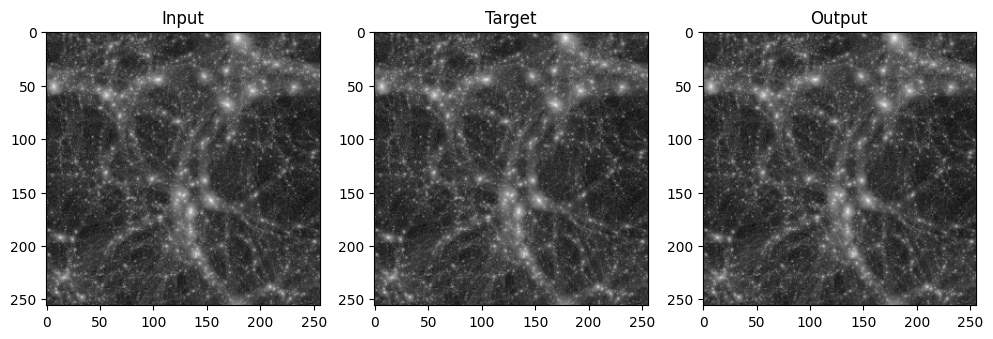

In [55]:
# Visualize results
Skip_UNet_model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = Skip_UNet_model(inputs)
        input_img, target_img, output_img = inputs[0, 0].cpu().numpy(), targets[0, 0].cpu().numpy(), outputs[0, 0].cpu().numpy()
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1); plt.title("Input"); plt.imshow(input_img, cmap='binary_r')
        plt.subplot(1, 3, 2); plt.title("Target"); plt.imshow(target_img, cmap='binary_r')
        plt.subplot(1, 3, 3); plt.title("Output"); plt.imshow(output_img, cmap='binary_r')
        plt.savefig('Perfect_100_epochs_image.png')
        plt.show()
        break

In [56]:
# Compute RMSE and PSNR
Skip_UNet_model.eval()
total_mse = 0
total_psnr = 0
num_batches = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        predictions = Skip_UNet_model(inputs)
        mse = criterion(predictions, targets)
        psnr = calculate_psnr(predictions, targets)

        total_mse += mse.item()
        total_psnr += psnr
        num_batches += 1

rmse = np.sqrt(total_mse / num_batches)
avg_psnr = total_psnr / num_batches

print(f"Test RMSE: {rmse:.4f}")
print(f"Test PSNR: {avg_psnr:.2f} dB")

Test RMSE: 0.0029
Test PSNR: 50.68 dB
